# <span style= 'color: #7A3803'>Curriculum Engagement and Usage Analysis
## <span style= 'color: #D16002'> Annie Carter's Exploratory Notebook  
- <span style= 'color: #EC9706'> Sourced by CodeUp, LLC

In [1]:
# Transform Libraries
import pandas as pd
import numpy as np
import os

#CAT Team Libraries
# import wrangle as w
# from env import user, hostname, password 
import env
# Visualization Libraries
import urllib.parse
import gzip
import seaborn as sns
import matplotlib.pyplot as plt

# Misc.  Libraries 
from sqlalchemy import create_engine
from io import BytesIO
from io import StringIO
from tabulate import tabulate

import warnings


## <span style= 'color: #7A3803'>  ACQUIRE & PREPARE

In [2]:
def get_connection(db, user=env.user, hostname=env.hostname, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{hostname}/{db}'

In [3]:
def get_sql_data():
    '''
    If the CSV file exists, it is read and returned as a pandas DataFrame.
    If not, pandas reads in a SQL query that acquires log data from a MySQL database.
    The query is stored into a DataFrame, saved, and returned.
    '''
    filename = 'curriculum_logs.csv'
    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        # Define SQL query, database parameters, and filename
        sql_query = """
            SELECT l.date, l.time, l.path as lesson, l.user_id, c.name as cohort, c.program_id,
                   l.ip, c.start_date, c.end_date
            FROM logs l
            JOIN cohorts c ON c.id=l.cohort_id;
        """
        db = 'curriculum_logs'
        user = env.user  # Replace with the actual value
        hostname = env.hostname  # Replace with the actual value
        password = env.password  # Replace with the actual value
        
        # Create a database connection using SQLAlchemy
        connection_string = get_connection(db, user, hostname, password)
        engine = create_engine(connection_string)
        
        # Fetch data from the database and convert it into a DataFrame
        logs_df = pd.read_sql(sql_query, get_connection('curriculum_logs'))
        
        # Convert 'date' and 'time' columns to a single 'datetime' column
        logs_df['date'] = pd.to_datetime(logs_df['date'] + ' ' + logs_df['time'])
        logs_df = logs_df.drop(['time'], axis=1)  # Drop 'time' column
        logs_df = logs_df.set_index('date')
        
        # Save the DataFrame as a CSV file
        logs_df.to_csv(filename, index=False)
        
        return logs_df

In [4]:
# Call the function to get and save the data
logs_df = get_sql_data()

In [5]:
logs_df.head()

,lesson,user_id,cohort,program_id,ip,start_date,end_date
0,/,1,Hampton,1,97.105.19.61,2015-09-22,2016-02-06
1,java-ii,1,Hampton,1,97.105.19.61,2015-09-22,2016-02-06
2,java-ii/object-oriented-programming,1,Hampton,1,97.105.19.61,2015-09-22,2016-02-06
3,slides/object_oriented_programming,1,Hampton,1,97.105.19.61,2015-09-22,2016-02-06
4,javascript-i/conditionals,2,Teddy,2,97.105.19.61,2018-01-08,2018-05-17


In [6]:
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847330 entries, 0 to 847329
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lesson      847329 non-null  object
 1   user_id     847330 non-null  int64 
 2   cohort      847330 non-null  object
 3   program_id  847330 non-null  int64 
 4   ip          847330 non-null  object
 5   start_date  847330 non-null  object
 6   end_date    847330 non-null  object
dtypes: int64(2), object(5)
memory usage: 45.3+ MB


In [7]:
logs_df.shape

(847330, 7)

## <span style= 'color: #7A3803'>  EXPLORATION AND ANALYSIS

# <span style= 'color: #D16002'>QUESTION 2
### <span style= 'color: #EC9706'>2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

In [8]:
logs_df['lesson'].nunique()

2224

In [9]:
logs_df['user_id'].nunique()

911

In [10]:
logs_df['cohort'].nunique()

47

In [11]:
# let's observe unique hits based on cohort
lesson_counts = logs_df.groupby('lesson')[['cohort', 'start_date','user_id']].nunique()
lesson_counts = lesson_counts.sort_values(by='cohort', ascending=False)
lesson_counts 

,cohort,start_date,user_id
lesson,,,
/,47,44,894
search/search_index.json,41,38,651
toc,40,39,624
java-i,40,39,599
html-css,40,39,680
...,...,...,...
appendix/testing-code.md,1,1,1
appendix/spring/seeder,1,1,1
appendix/spring/security-use-cases,1,1,1


In [12]:

# logs_df.groupby(['index'/date])[[ cohort 'lesson', 'user_id']].nunique()sort.('name'ascending, False)
result = logs_df.groupby([logs_df.index])[['cohort','lesson','user_id']].nunique('lesson')
result = result.sort_values(by='lesson', ascending=False)
result

,cohort,lesson,user_id
0,1,1,1
564891,1,1,1
564881,1,1,1
564882,1,1,1
564883,1,1,1
...,...,...,...
282448,1,1,1
282449,1,1,1
282450,1,1,1
847329,1,1,1


In [13]:
def question2_1(logs_df):
    '''This function determines which lesson was most and least refered to by cohort'''
    #Find lesson counts"
    lesson_counts = logs_df.groupby('lesson')[['cohort', 'start_date','user_id']].nunique()
    lesson_counts = lesson_counts.sort_values(by='cohort', ascending=False)
    # Find the lesson that was refered to the most 
    most_referred_cohort = lesson_counts['cohort'].idxmax()
    most_referred_count = lesson_counts.loc[most_referred_cohort, 'cohort']
    
    # Find the lesson that referred to the the least
    least_referred_cohort = lesson_counts['cohort'].idxmin()
    least_referred_count = lesson_counts.loc[least_referred_cohort, 'cohort']
    
    print(f"The lesson that was referred to the the most: {most_referred_cohort} with {most_referred_count} referrals.")
    print(f"The lesson that referred to the the least: {least_referred_cohort} with {least_referred_count} referrals.")
 

In [14]:
question2_1(logs_df)  

The lesson that was referred to the the most: / with 47 referrals.
The lesson that referred to the the least: java-i/loops with 1 referrals.


In [15]:
def question2_2(logs_df):
    '''This function groups data by cohort and lesson to determine the lesson with the highest and lowest counts by cohort'''
    # Group data by cohort and lesson, then calculate the size (count of occurrences)
    cohort2 = logs_df.groupby(['cohort', 'lesson']).size()
    # Reset the index and rename the count column
    cohort2 = cohort2.reset_index(name='count')
    # Filter the DataFrame to show only the rows where lesson is '/' and  count in descending order
    cohort2 = cohort2.loc[cohort2['lesson'] == '/'].sort_values(by='count', ascending=False)
    return cohort2.head(), cohort2.tail()

In [16]:
question2_2(logs_df)

(          cohort lesson  count
 9500       Staff      /   6340
 2891      Darden      /   2980
 11855  Voyageurs      /   2101
 4262     Fortuna      /   2038
 1304       Bayes      /   1967,
           cohort lesson  count
 5647      Joshua      /      8
 4520    Franklin      /      4
 3598      Denali      /      1
 639       Apollo      /      1
 4099  Everglades      /      1)

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

def question2_graph(logs_df):
    '''This function groups data by cohort and lesson to determine the lesson with the highest and lowest counts by cohort'''
    # Group data by cohort and lesson, then calculate the size (count of occurrences)
    cohort2 = logs_df.groupby(['cohort', 'lesson']).size()
    # Reset the index and rename the count column
    cohort2 = cohort2.reset_index(name='count')
    # Filter the DataFrame to show only the rows where lesson is '/' and  count in descending order
    cohort2 = cohort2.loc[cohort2['lesson'] == '/'].sort_values(by='count', ascending=False)
    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(data=cohort2, x='cohort', y='count', palette='Oranges')
    plt.xlabel('Cohort')
    plt.ylabel('Lesson / Count')
    plt.title('Lesson with Highest Count by Cohort')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



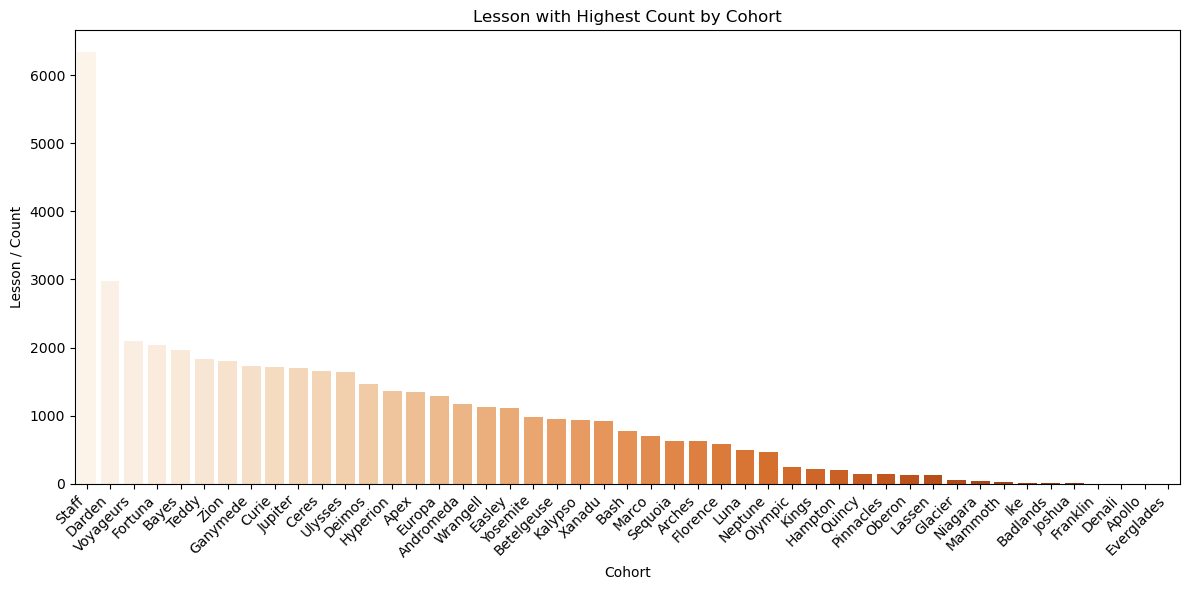

In [18]:
# Call the function with your logs_df bDataFrame
question2_graph(logs_df)

###  <span style ='color:#D16002'> QUESTION 2 Findings
#### <span style= 'color: #EC9706'>Q2 Findings:
#### <span style= 'color: #EC9706'> **Methodology and Insights:**Initial Identification: Anomalies were spotted by comparing the engagement counts of each cohort with the '/' lesson. The homepage marked as "/" received the highest number of accesses. Remarkably, the "Darden" cohort, aside from "Staff," exhibited a substantial engagement with this lesson, accessing it a notable 2980 times. This count surpassed the single access recorded for the Denali, Apollo, and Everglades cohorts.
- The difference in engagement between cohort 'Darden' and the other cohorts for the lesson '/' indicates a potential anomaly that requires further investigation.
.'
#### <span style= 'color: #EC9706'>**Recommendation:** Additional qualitative research will delve into factors like curriculum content, teaching methods, or cohort dynamics to understand the anomaly's underlying causes.

# <b>___________________________________________________________________________________________________________</b>

## <span style= 'color: #D16002'> QUESTION 3
### <span style= 'color: #EC9706'>3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?


##### Explore Q3

In [19]:
page_views = logs_df.groupby(['user_id'])['lesson', 'ip', 'cohort'].agg(['count', 'nunique'])
page_views = page_views.sort_values(by=[('lesson', 'count'), ('ip', 'count')], ascending=False)
page_views.head()


/var/folders/0f/gkm6knzn3fscjt7dxlgc9k5h0000gn/T/ipykernel_92800/2379890132.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  page_views = logs_df.groupby(['user_id'])['lesson', 'ip', 'cohort'].agg(['count', 'nunique'])


lesson             ip         cohort        
         count nunique  count nunique  count nunique
user_id                                             
11       17913     871  17913      32  17913       2
64       16322     436  16322      34  16322       3
53       12329     333  12329      15  12329       2
314       7783     225   7783      49   7783       2
1         7404     976   7404      35   7404       2

In [20]:
student = logs_df.groupby(['user_id', 'lesson']).value_counts()
student = student.reset_index(name='count')
student = student.sort_values(by='count', ascending=False)
student

,user_id,lesson,cohort,program_id,ip,start_date,end_date,count
4313,11,/,Staff,2,97.105.19.58,2014-02-04,2014-02-04,571
85064,428,jquery/ajax/weather-map,Staff,2,70.121.183.95,2014-02-04,2014-02-04,529
14146,53,index.html,Lassen,1,97.105.19.58,2016-07-18,2016-11-10,501
15453,64,/,Staff,2,71.150.217.33,2014-02-04,2014-02-04,448
4314,11,/,Staff,2,76.185.145.231,2014-02-04,2014-02-04,407
...,...,...,...,...,...,...,...,...
80747,414,javascript-i/loops,Betelgeuse,2,66.25.166.124,2019-05-28,2019-10-08,1
80746,414,javascript-i/loops,Betelgeuse,2,68.206.254.17,2019-05-28,2019-10-08,1
80745,414,javascript-i/loops,Betelgeuse,2,76.185.135.244,2019-05-28,2019-10-08,1
80743,414,javascript-i/javascript-with-html,Betelgeuse,2,68.206.254.17,2019-05-28,2019-10-08,1


In [24]:
def question3_1(logs_df):
    '''This function outlines the steps to find user engagement'''
    # Calculate engagement for each user by counting unique views of curriculum
    user_engagement = logs_df.groupby('user_id')['lesson'].nunique()
    
    # Set a threshold for low engagement (e.g., fewer than 3 unique lessons)
    threshold = 3
    
    # Filter for students with low engagement
    low_engagement_students = user_engagement[user_engagement < threshold]
    
    # Get information about these low engagement students
    low_engagement_info = logs_df[logs_df['user_id'].isin(low_engagement_students.index)].sort_values('user_id').tail()
    
    # Count how many times each user accessed 'lesson' == '/'
    lesson_count_slash = logs_df[logs_df['lesson'] == '/'].groupby('user_id').size()
    
    # Add the lesson count to the low_engagement_info DataFrame
    low_engagement_info['lesson_count_slash'] = low_engagement_info['user_id'].map(lesson_count_slash)
    
    return low_engagement_info


In [25]:
question3_1(logs_df)

,lesson,user_id,cohort,program_id,ip,start_date,end_date,lesson_count_slash
794828,/,940,Neptune,2,70.121.129.79,2021-03-15,2021-09-03,1
829334,/,952,Olympic,1,70.125.158.82,2017-02-06,2017-05-25,1
835280,/,980,Staff,2,97.105.19.60,2014-02-04,2014-02-04,3
837056,/,980,Staff,2,97.105.19.60,2014-02-04,2014-02-04,3
843262,/,980,Staff,2,97.105.19.60,2014-02-04,2014-02-04,3


In [26]:
def question3_graph1(logs_df):
    '''This graph finds user error and creates a theshold of 3 so any user with less than 3 will be filtered for low engagemet'''
    # Calculate engagement for each user by counting unique lessons
    user_engagement = logs_df.groupby('user_id')['lesson'].nunique()
    
    # Set a threshold for low engagement (e.g., fewer than 3 unique lessons)
    threshold = 3
    
    # Filter for students with low engagement
    low_engagement_students = user_engagement[user_engagement < threshold]
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    le = plt.hist(user_engagement, bins=20, color='orange', edgecolor='black', alpha=0.7, label='Engagement Distribution')
    plt.axvline(x=threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
    plt.scatter(low_engagement_students.index, [0] * len(low_engagement_students), color='red', label='Low Engagement Students')
    plt.xlabel('Number of Unique Lessons')
    plt.ylabel('Number of Students')
    plt.title('Anomaly Detection: Engagement Distribution and Low Engagement Students')
    plt.legend()
    
    # Add count numbers on bars
    for p in le[2]:  # le[2] contains the patches
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        offset = width * 0.02  # Adjust the offset percentage as needed
        plt.annotate(format(height, '.0f'), (x + width / 2., y + height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()
    

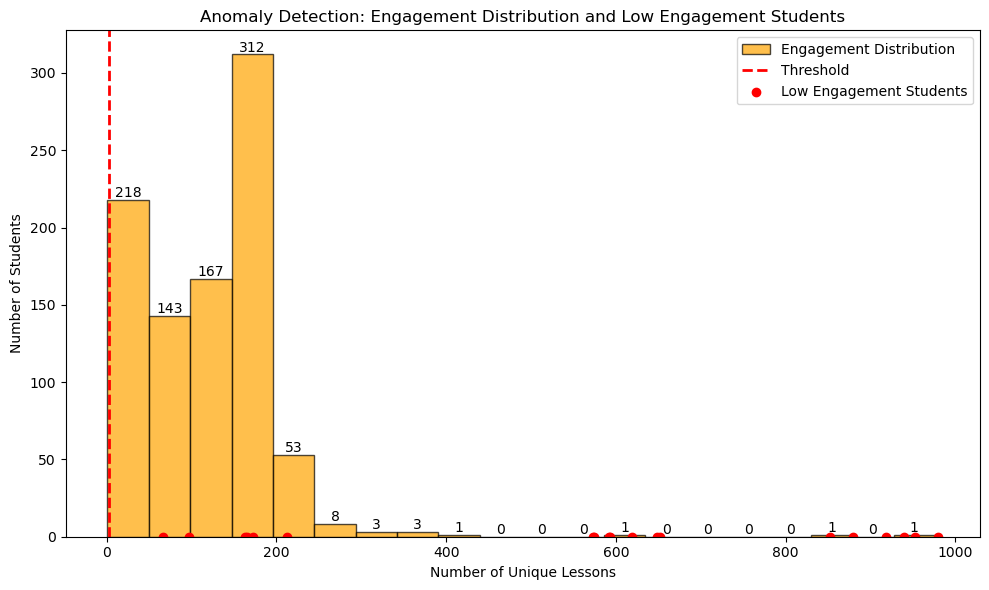

In [27]:
question3_graph1(logs_df)

###  <span style ='color:#D16002'> QUESTION 3 Findings
#### <span style= 'color: #EC9706'> **Methodology and Insights:** Through our analysis, we identified active students with minimal curriculum interaction, defined by engaging with fewer than three unique lessons. This low engagement hints at potential challenges or missed opportunities in their learning journey.

- Limited Lesson Diversity: These students often interacted with a small range of lessons, suggesting a lack of exploration.
- Addressing Challenges: Challenges such as time constraints or difficulties with material may contribute to low engagement.
- Early Intervention: Detecting low engagement early can enable timely support and tailored interventions.

#### <span style= 'color: #EC9706'>**Recommendation:** To enhance engagement and support learning, we suggest implementing proactive measures, such as personalized assistance and additional resources, for students displaying minimal curriculum interaction.

### Additional Codes used during exploration, but not for final notebook
### Q2 did not use this code

In [ ]:
#Q2 used this code but refined
# cohort2 = logs_df.groupby(['cohort', 'lesson']).size()
# cohort2 = cohort2.reset_index(name='count')
# cohort2 = cohort2.sort_values(by='count', ascending=False)
# cohort2 = corhort2.iloc('/').sort_values
# cohort2



# # let's observe unique hits based on cohort
# cohort_counts = logs_df.groupby('cohort')[['user_id', 'start_date','lesson']].nunique()
# cohort_counts 

In [ ]:
#Q2 used this code but refined
# lesson_result = logs_df.groupby([logs_df.index])[['cohort','lesson','user_id']].nunique('lesson')
# lesson_result = result.sort_values(by='lesson', ascending=False)
# lesson_result

# cohort_counts = logs_df.groupby(['cohort', 'lesson']).value_counts()
# cohort_counts = cohort_counts.sort_values(by='lesson', ascending=False)


# # cohort = logs_df.groupby(['cohort'])[['lesson']].nunique('lesson')
# # cohort = cohort.reset_index(name='count')
# # cohort = cohort.sort_values(by='count', ascending=False)
# cohort_counts

### Q3 did not use this code

In [ ]:
# # logs_df.groupby(['index'/date])[[ cohort 'lesson', 'user_id']].nunique()sort.('name'ascending, False)
# result2 = logs_df.groupby(['user_id'])[['lesson','ip']].nunique('lesson')
# result2 = result2.sort_values(by='ip', ascending=False)
# result2

In [ ]:
# Set the threshold as a percentage (e.g., 10%)
threshold_percentage = 0.1

# Calculate the total unique lessons
total_unique_lessons = logs_df['lesson'].nunique()

# Calculate the threshold value based on the percentage and total unique lessons
threshold = total_unique_lessons * threshold_percentage

# Group data by user_id and count unique lessons and IPs
user_engagement = logs_df.groupby('user_id').agg(unique_lessons=('lesson', 'nunique'),
                                                unique_ips=('ip', 'nunique'))

# Sort the results based on the count of unique lessons
user_engagement = user_engagement.sort_values(by='unique_lessons', ascending=False)

# Filter for students with low curriculum access
low_access_students = user_engagement[user_engagement['unique_lessons'] <= threshold]


low_access_students


In [ ]:
#Not as clear as graph 1 will not be in final notebook

# Calculate engagement for each user by counting unique lessons
user_engagement = logs_df.groupby('user_id')['lesson'].nunique()

# Set a threshold for low engagement (e.g., fewer than 3 unique lessons)
threshold = 3

# Filter for students with low engagement
low_engagement_students = user_engagement[user_engagement < threshold]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(user_engagement.index, user_engagement, color='lightblue', label='Engagement')
plt.bar(low_engagement_students.index, low_engagement_students, color='red', label='Low Engagement')
plt.axhline(y=threshold, color='orange', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('User ID')
plt.ylabel('Number of Unique Lessons')
plt.title('Anomaly Detection: Engagement Distribution and Low Engagement Students')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [ ]:
# import pandas as pd
# from tabulate import tabulate

# # Calculate engagement for each user by counting unique lessons
# user_engagement = logs_df.groupby('user_id')['lesson'].nunique()

# # Set a threshold for low engagement (e.g., fewer than 3 unique lessons)
# threshold = 3

# # Filter for students with low engagement
# low_engagement_students = user_engagement[user_engagement < threshold]

# # Get information about these low engagement students
# low_engagement_info = logs_df[logs_df['user_id'].isin(low_engagement_students.index)]

# # Sort the low engagement students' information by user ID and unique counts
# sorted_low_engagement_info = low_engagement_info.sort_values(by=['user_id', 'lesson'], ascending=[True, True])

# # Display the sorted low engagement students' information in a table
# table = tabulate(sorted_low_engagement_info, headers='keys', tablefmt='pretty')
# print(f'Sorted Low Engagement Students:\n{table}')

# # Display the rest of the logs_df data for the sorted low engagement students' user IDs
# rest_of_logs_df = logs_df[logs_df['user_id'].isin(sorted_low_engagement_info['user_id'])]
# print('Rest of logs_df data for Sorted Low Engagement Students:')
# print(rest_of_logs_df)


In [ ]:
# # Sample data for demonstration
# data = logs_df

# logs_df = pd.DataFrame(data)

# # Set the threshold as a percentage (e.g., 20%)
# threshold_percentage = 0.2

# # Calculate the total unique lessons
# total_unique_lessons = logs_df['lesson'].nunique()

# # Calculate the threshold value based on the percentage and total unique lessons
# threshold = total_unique_lessons * threshold_percentage

# # Group data by user_id and count unique lessons and IPs
# user_engagement = logs_df.groupby('user_id').agg(unique_lessons=('lesson', 'nunique'),
#                                                 unique_ips=('user_id', 'nunique'))

# # Sort the results based on the count of unique lessons
# user_engagement = user_engagement.sort_values(by='unique_lessons', ascending=False)

# # Filter for students with low curriculum access
# low_access_students = user_engagement[user_engagement['unique_lessons'] <= threshold]

# # Display low access students
# print("Low Access Students:")
# low_access_students.tail()

# # Ignore the "ValueError" warning
# warnings.filterwarnings("ignore", category=UserWarning)
# # Find cohorts with the most students with the lowest engagement
# cohort_with_lowest_engagement = logs_df[logs_df['user_id'].isin(low_access_students.index)]
# cohort_low_engagement_counts = cohort_with_lowest_engagement['cohort'].value_counts()
# print("\nCohort with Most Students with Lowest Engagement:")
# print(cohort_low_engagement_counts)

# # Crosstab program and low access students to find lowest engagement program
# lowest_engagement_program = pd.merge(index=low_access_students.index, columns=logs_df['program_id'])
# print("\nLowest Engagement Program:")
# print(lowest_engagement_program)



In [ ]:
# def question3_1(logs_df):
#     '''This function outlines the steps to find user engagement'''
#     # Calculate engagement for each user by counting unique lessons
#     user_engagement = logs_df.groupby('user_id')['lesson'].nunique()
    
#     # Set a threshold for low engagement (e.g., fewer than 3 unique lessons)
#     threshold = 3
    
#     # Filter for students with low engagement
#     low_engagement_students = user_engagement[user_engagement < threshold]
    
#     # Get information about these low engagement students
#     low_engagement_info = logs_df[logs_df['user_id'].isin(low_engagement_students.index)].sort_values(by='user_id').tail()
    
#     # Display low engagement information
#     print("Low Engagement Students Information:")
    
#     return low_engagement_info


In [21]:
# def question3_1a(logs_df):
#     # Calculate engagement for each user by counting unique lessons
#     user_engagement = logs_df.groupby['user_id']['lesson'].nunique()

#     # Set a threshold for low engagement (e.g., fewer than 3 unique lessons)
#     threshold = 3

#     # Filter for students with low engagement
#     low_engagement_students = user_engagement[user_engagement < threshold]

#     # Get information about these low engagement students
#     low_engagement_info = logs_df[logs_df['user_id'].isin(low_engagement_students.index)]

#     # Additional details of students
#     # Group by user_id, lesson, ip, and cohort, and aggregate counts and unique counts
#     page_views = logs_df.groupby(['user_id'])[['lesson', 'ip', 'cohort']].agg(['count', 'nunique'])

#     # Sort the page_views DataFrame by 'user_id' count in ascending order
#     page_views_sorted = page_views.sort_values(by=[('user_id', 'count')], ascending=True)

#     # Extract additional details about students with low curriculum access
#     low_access_students = page_views_sorted[page_views_sorted[('lesson', 'count')] < threshold].index
#     details_about_low_access_students = logs_df[logs_df['user_id'].isin(low_access_students)].sort_values(by=['user_id', 'lesson', 'end_date'], ascending=True)

#     # Print the results
#     print("Details about Low Engagement Students:")
#     print(low_engagement_info)

#     print("\nDetails about Low Access Students:")
#     print(details_about_low_access_students)
